In [10]:
# Mount driver to authenticate yourself to google drive:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Change to your own folder:
my_dir = "/content/drive/MyDrive/Colab Notebooks/2023 VSL stimulus + behavior"

In [12]:
# @title Import packages

import os
import re
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.metrics import pairwise_distances
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from tqdm.notebook import tqdm

In [13]:
# @title Use GPU

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU available:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("No GPU found")
        # Please check if GPU is enabled in 'Runtime' -> 'Change runtime type' menu

No GPU found


# Define Functions

In [14]:
# @title preprocess_stimuli_to_tensor()

def preprocess_stimuli_to_tensor(image):

    preprocess = transforms.Compose([
        transforms.Resize(224),     # Scales the shorter side of the image, and keep the aspect ratio
        transforms.CenterCrop(224), # Required input size of GoogLeNet
        transforms.ToTensor(),      # Convert the image to a PyTorch tensor
        transforms.Normalize(       # Normalize the pixel values to the range [0, 1]
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)

    # Move the image to the CPU and convert the tensor to numpy array:
    image_np = image.cpu().numpy()

    # Clip the values to the valid range [0, 1] for visualization:
    image_np = np.clip(image_np, 0, 1)

    return image, image_np

In [15]:
# @title record_model_outputs()

def record_model_outputs(model, processed_stimuli, selected_layers):
    '''
    see: https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/#forward-hooks-101
    '''
    model.eval()  # Set the model to evaluation mode
    output_features = {}

    # Function to register hooks for the selected layers:
    def register_hooks(name):
        def hook_fn(module, input, output):
            output_features[name] = output.detach()
        return hook_fn

    # Register forward hooks on the layers of choice:
    hooks = []
    for name, module in model.named_modules():
        if name in selected_layers:
            h = module.register_forward_hook(register_hooks(name))
            hooks.append(h)

    # Forward pass:
    '''
    Since we are only interested in the outputs,
    we don't need to compute gradients for any further training (backpropagation).
    '''
    with torch.no_grad():
        outputs = model(processed_stimuli)

    # Remove the hooks to free up memory
    for hook in hooks:
        hook.remove()

    return outputs, output_features


In [16]:
# @title calculate_RDM()

def calculate_RDM(X, meas='1-corr'):
    '''
    Args:
      X (numpy.array <OR> torch.tensor): S x N array, where S is the number of stimuli
                                         and N is the number of features
    Returns:
      RDM (np.ndarray): S x S representational dis-similarity matrix
    '''
    if torch.is_tensor(X):
        X = torch.flatten(X, 1).detach().cpu().numpy()
    X = X.reshape(X.shape[0], -1)

    if meas == '1-corr':
        z_X = zscore(X, axis=1)
        RDM = 1 - np.matmul(z_X, z_X.T) / z_X.shape[1]
    else:
        RDM = pairwise_distances(X, metric=meas)

    return RDM

In [17]:
# @title plot_RDM()

def plot_RDM(rdm, rdm_cmap="coolwarm",
             fig_size=(5, 5), font_size=12, 
             fig_title="", fp=None):
    # Mask the upper triangle:
    mask = np.zeros_like(rdm)
    mask[np.triu_indices_from(rdm)] = 1

    # Plotting:
    plt.figure(figsize=fig_size)
    sns.set(style='white', font_scale=1)
    ax = sns.heatmap(rdm, cmap=rdm_cmap, mask=mask, square=True)
    ax.set_xticklabels(range(1, 13))
    ax.set_yticklabels(range(1, 13))
    ax.set_title(fig_title, fontsize=font_size)
    if fp is not None:
        plt.savefig(fp, format='png')
    plt.show()

In [18]:
# @title perform_PCA()

def perform_PCA(X, explained=.9, top_k=None):
    '''
    Args:
        X (numpy.array): S x N matrix
    Returns:
        top_k (int)          : Number of dimensions to reduce
        X_recon (numpy.array): The reduced data with ndims dimensionality
    '''
    # Calculate the sample covariance matrix:
    sample_cov_matrix = np.cov(X.T, bias=True) # default normalization is by (N - 1)

    # Calculate the eigenvectors of the sample covariance matrix:
    evals, evectors = np.linalg.eigh(sample_cov_matrix)

    if top_k is None:
        # Sort the eigenvalues in descending order:
        index = np.flip(np.argsort(evals)) # reversed indices
        evals = evals[index]
        evectors = evectors[:, index]

        # Calculate the variance explained:
        variance_explained = np.cumsum(evals) / np.sum(evals)
        top_k = np.where(variance_explained > explained)[0][0] + 1 # python index start from 0

    # Reconstruct the data based on the top K components:
    X_recon = X[:, :top_k] @ evectors[:, :top_k].T + np.mean(X, axis=0)

    return top_k, X_recon


# GoogLeNet

In [19]:
# @title Load and Preprocess the stimuli

stimuli = []
for fn in sorted(glob.glob(os.path.join(my_dir, 'png', '*')),
                 key=lambda s: int(re.search(r'\d+', s).group())):
    image = Image.open(fn).convert('RGBA')
    white_background = Image.new('RGBA', image.size, (255, 255, 255))
    image = Image.alpha_composite(white_background, image)
    image = image.convert('RGB')
    stimuli.append(image)

processed_stimuli = torch.stack([ preprocess_stimuli_to_tensor(stim)[0] for stim in stimuli ])
processed_stimuli = processed_stimuli.requires_grad_(False)

print(processed_stimuli.shape)

torch.Size([12, 3, 224, 224])


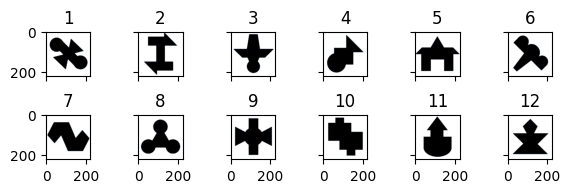

In [20]:
# @title Visualize the stimuli
processed_visualize = [ preprocess_stimuli_to_tensor(stim)[1] for stim in stimuli ]

fig, axs = plt.subplots(2, 6, figsize=(6, 2), sharex=True, sharey=True)
for ax, stim, idx in zip(axs.flat, processed_visualize, range(1, 13)):
    ax.imshow(stim.transpose(1, 2, 0), cmap="gray")
    ax.set_title(idx)
fig.tight_layout()
fig.show()

In [21]:
# @title Load the pretrained model
  # https://pytorch.org/hub/pytorch_vision_googlenet/
  # https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7298594
  # https://zhuanlan.zhihu.com/p/185025947

model_name = 'googlenet'
from torchvision.models import GoogLeNet_Weights
model = torch.hub.load('pytorch/vision:v0.10.0', model_name, weights=GoogLeNet_Weights.IMAGENET1K_V1)

model = model.to(device)
print(len(list(model.modules())))

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 87.9MB/s]


224


In [22]:
# @title Select layers and Record outputs

layer_names = ['3a', '3b', '4a', '4b', '4c', '4d', '4e', '5a', '5b']
# layer_names = layer_names[-4:]
  # last 4 layers of GoogLeNet,
  # same as: https://elifesciences.org/articles/68344#fig2s2

selected_layers = [ f'inception{name}' for name in layer_names ]
outputs, output_features = record_model_outputs(model, processed_stimuli, selected_layers)

In [23]:
# @title Compute RDMs and save to files

save_path = os.path.join(my_dir, f"{model.__class__.__name__}")
if not os.path.exists(save_path):
    os.makedirs(save_path)

RDMs = {}
measurements = ['1-corr', 'euclidean']

for meas in measurements:
    RDMs[meas] = {}

    for name in selected_layers:
        fpath = os.path.join(save_path, f"{model_name}_RDMs-{meas}_{name}.csv")
        rdm = calculate_RDM(output_features[name], meas='1-corr')
        RDMs[meas][name] = rdm
        np.savetxt(fpath, rdm, delimiter=",")

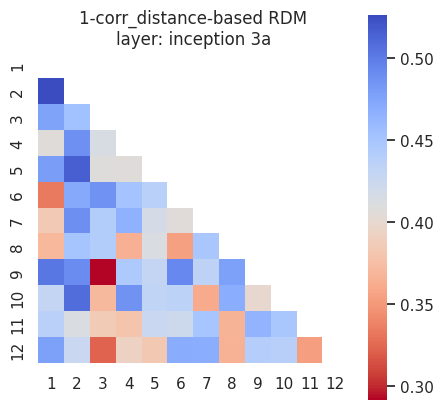

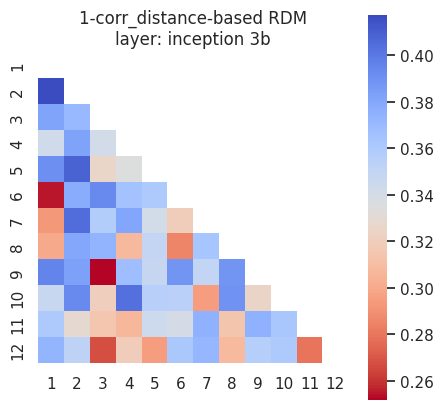

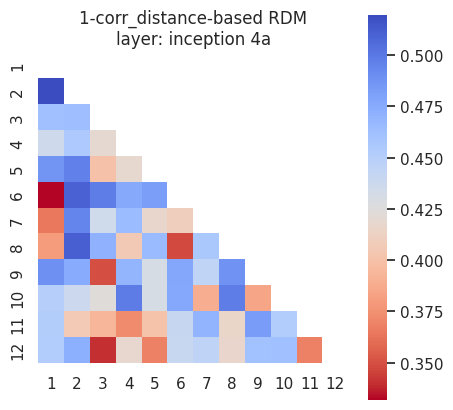

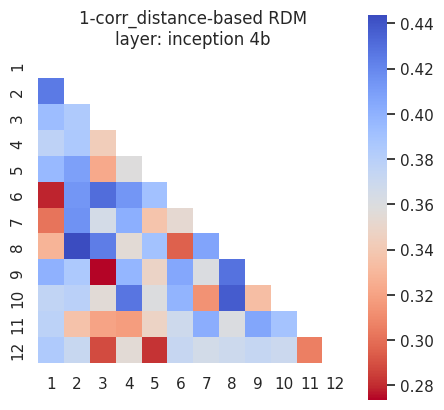

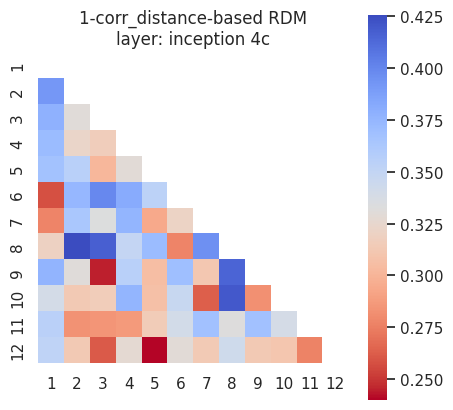

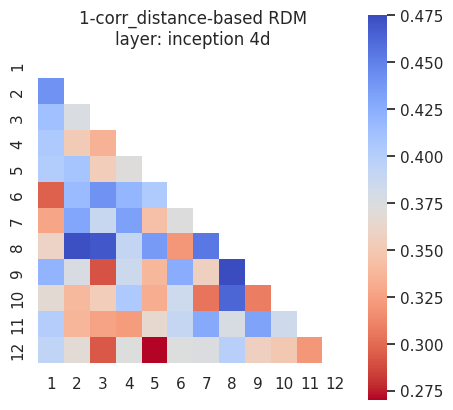

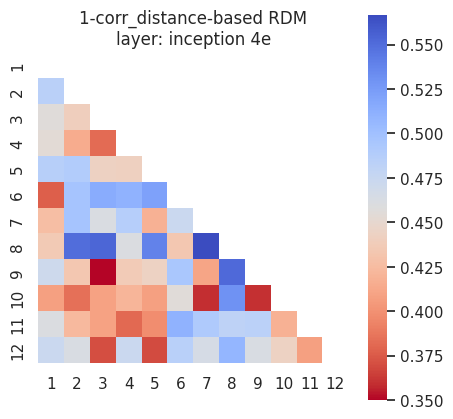

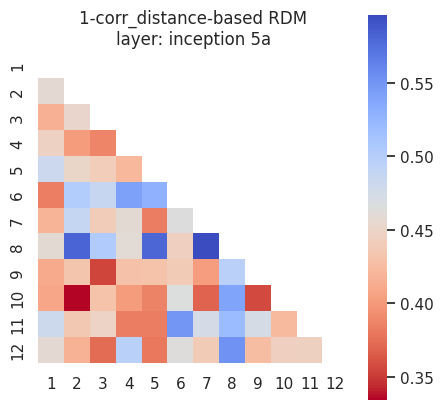

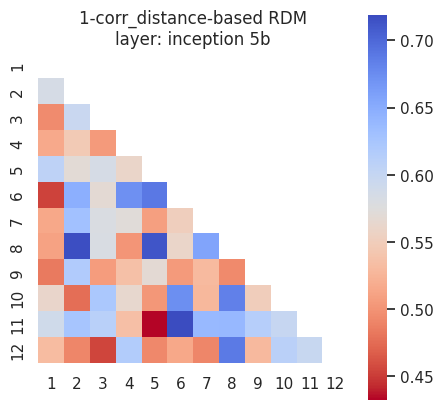

In [28]:
# @title Plot RDMs

meas = measurements[0]
c_map = ["Blues", "jet", "coolwarm_r"][2]

for x, name in enumerate(selected_layers):
    rdm = RDMs[meas][name]
    layer_name = layer_names[x]
    plot_RDM(rdm, c_map,
             fig_title=f"{meas}_distance-based RDM\nlayer: inception {layer_name}", 
             fp=os.path.join(save_path, f"{model_name}_RDMs-{meas}_{name}.png"))

In [26]:
# @title Correlation between RDMs

meas = measurements[1]
flatten_RDMs = {}

for name in selected_layers:
    rdm = RDMs[meas][name]
    flatten_RDMs[name] = rdm[np.tril_indices(rdm.shape[0], -1)]

flatten_RDMs = pd.DataFrame.from_dict(flatten_RDMs)
flatten_RDMs.columns = layer_names
melted_flatten_RDMs = flatten_RDMs.melt(var_name="layer", value_name="distance")
# melted_flatten_RDMs.layer = melted_flatten_RDMs.layer.apply(lambda x: x.replace("inception", ""))


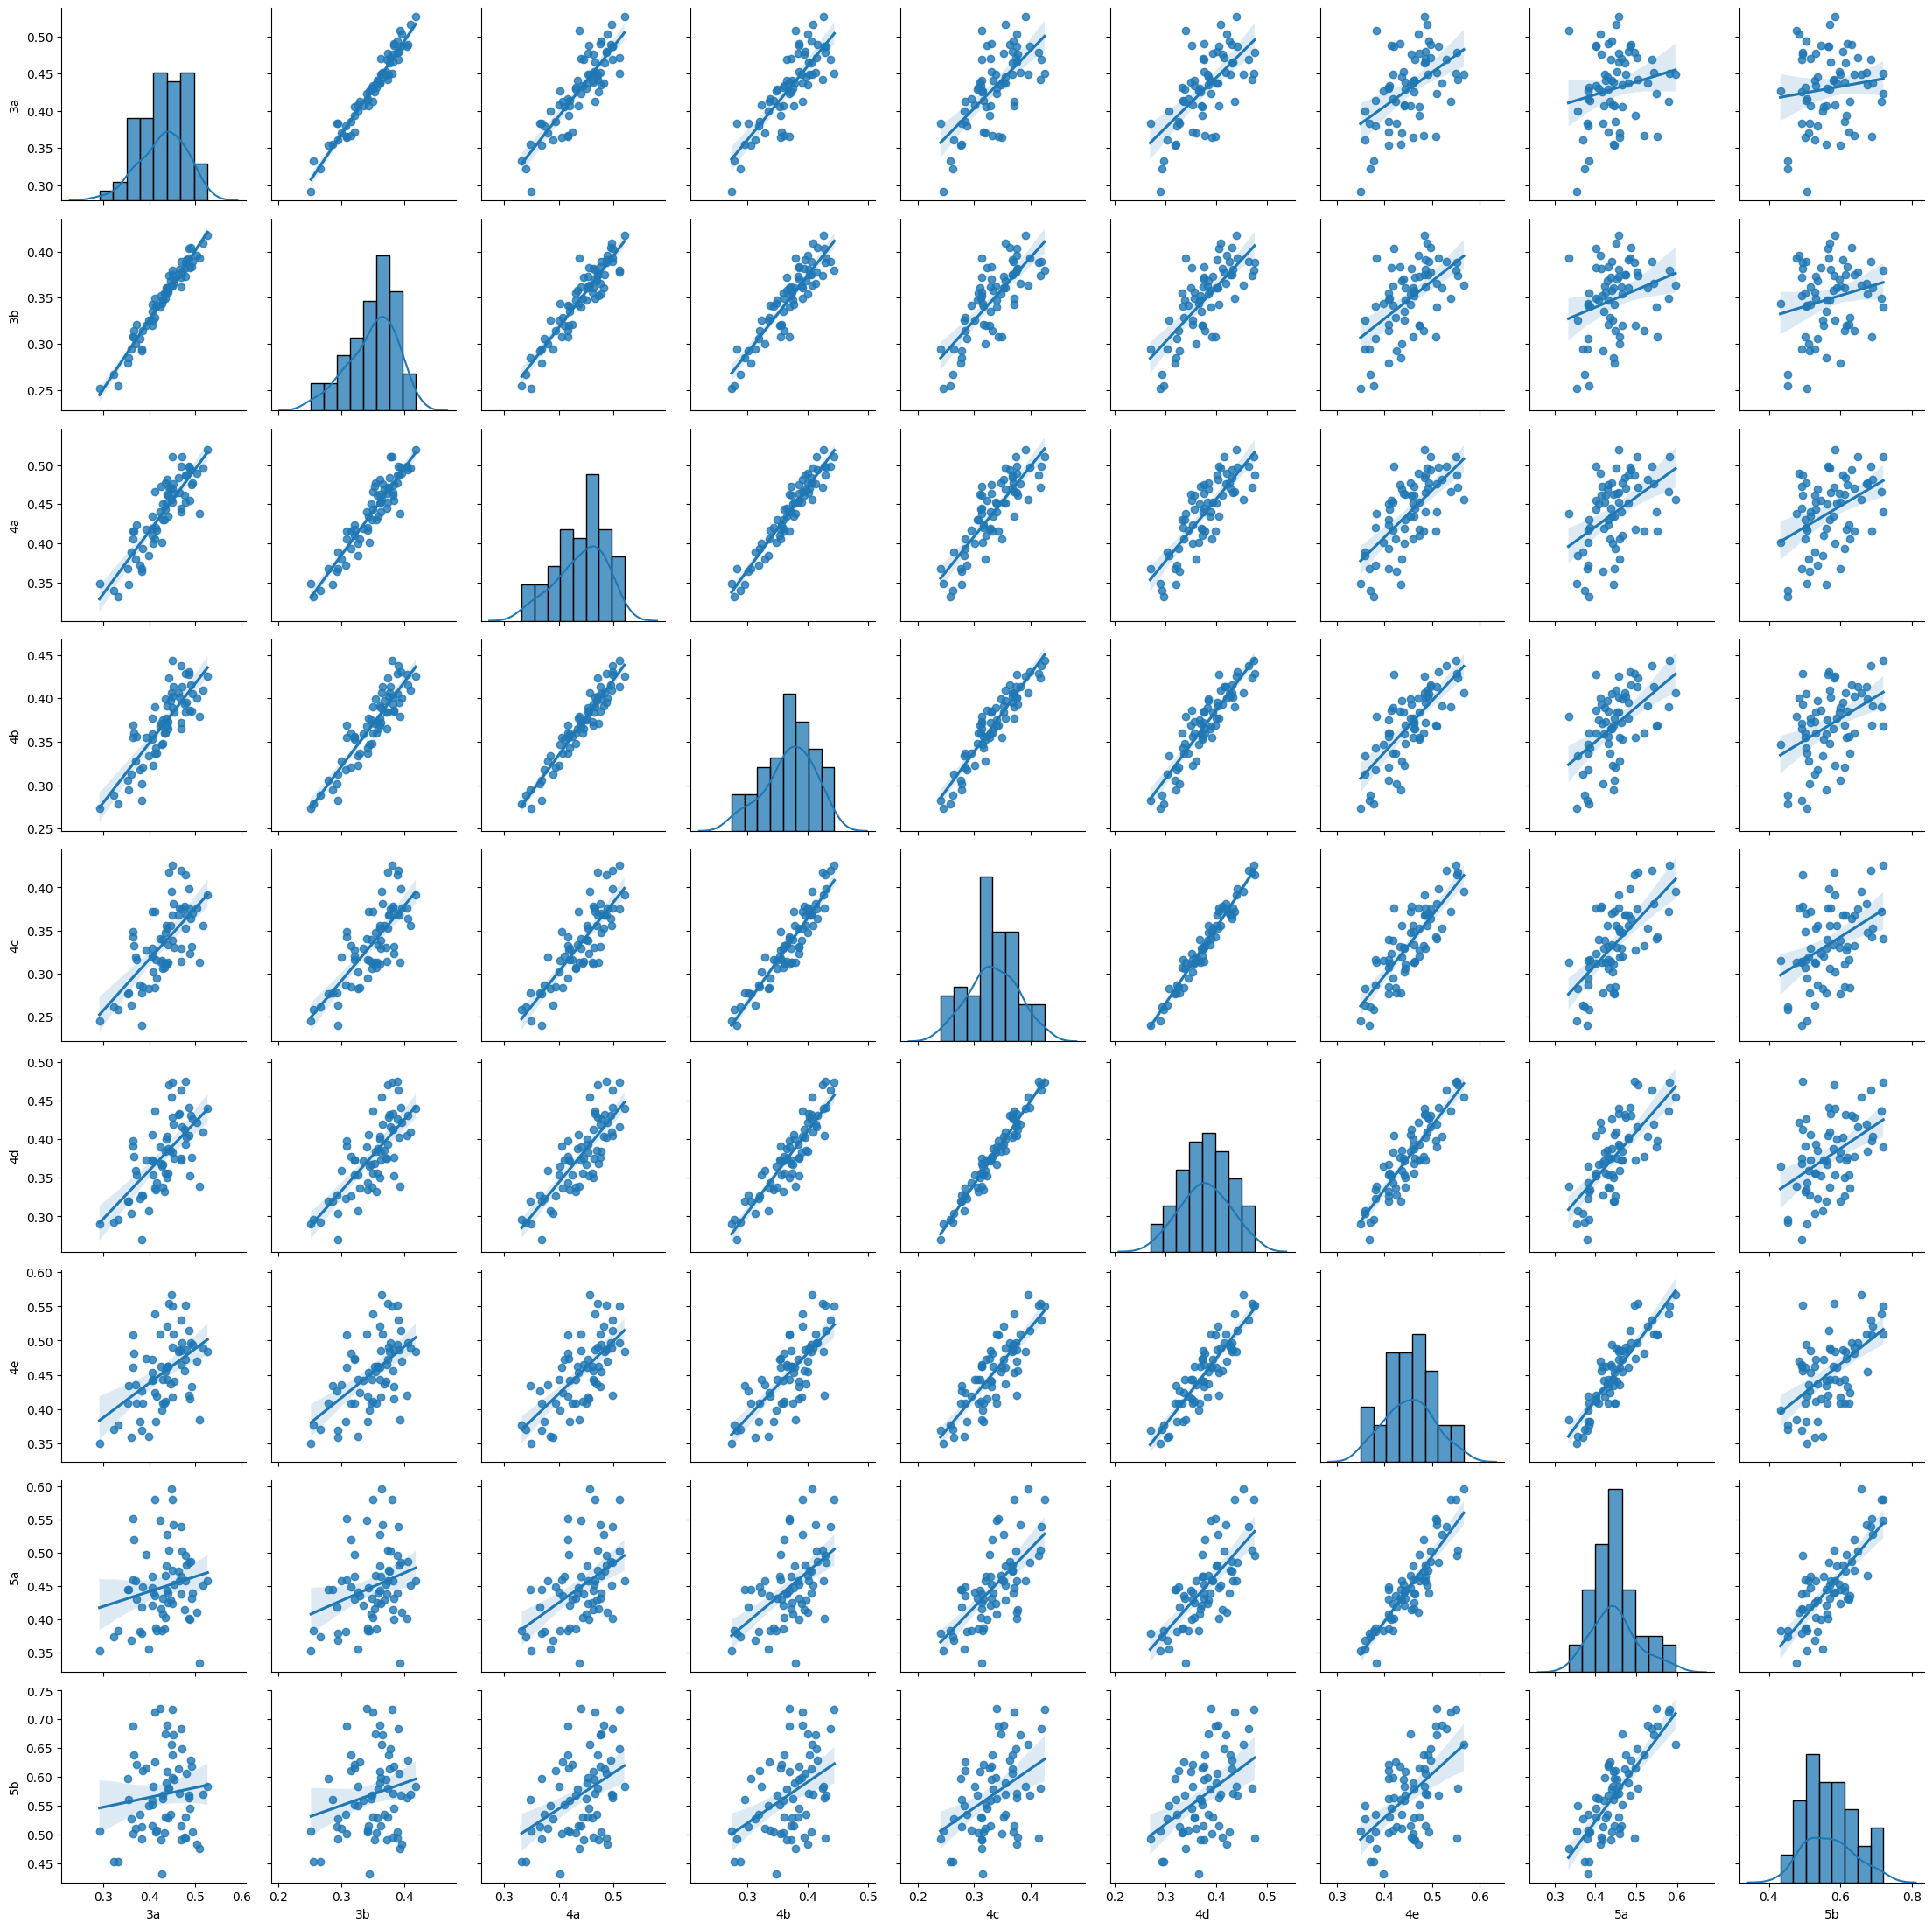

In [ ]:
# @title Visualize pairwise relationships
  # see more: https://seaborn.pydata.org/tutorial/axis_grids.html#plotting-pairwise-data-relationships

# g = sns.FacetGrid(melted_flatten_RDMs, col="layer")
# g.map(sns.histplot, "distance")
# g.map(sns.kdeplot, "distance")

g = sns.PairGrid(flatten_RDMs)
g.map_diag(sns.histplot)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.regplot)
# g.set(xticks=[.2, .4, .6, .8], yticks=[.2, .4, .6, .8])

# Experimental data

In [ ]:
# @title Define variables

stim_type = 'shape_png'
# stim_type = 'tpl_sorted' # Triplets are sorted by familarity scores for each subject (A>B>C>D)
afni_ver = 'runs_v+'     # separately modeling for each run, NOT trial-wise estimation
tstats = True            # Parameter estimation use T-statistics (instead of Betas values)
reml = ['', '_REML'][1]  # REML: REstricted Maximum Likelihood
estm_ver = f'Tstats{reml}' if tstats else 'Betas'
meas = 'Pearson_r_z'     # RSM measurement
run_list = ['run-01', 'run-10']
roi_list = [
    'DG', 'CA3', 'CA1', 'Sub', # Hippocampal subregions
    'PHC', 'PRC', 'ERC',       # MTC cortices
    'HPC', 'MTL', 'HPC+MTL',   # Combined
    'Caudate', 'Putamen',
    'Lat_Occi', 'Inf_Temp',    # High-level visual cortices
    # 'V1',  'V2',
    'v1',  'v2',  'V3',
    'hV4',         # responds to color: https://www.nature.com/articles/nn1507
    'VO1', 'VO2',  # ventral occipital areas 1 (VO1) and 2 (VO2)
    'CBM'
 ]

In [ ]:
# @title Define directories

top_dir = my_dir
behav_dir = os.path.join(top_dir, 'behavioral_data', 'familarity_test')
pyrsa_dir = os.path.join(top_dir, '..', '2023 VSL fMRI', 'PyRSA')
rsm_top_dir = os.path.join(pyrsa_dir, 'similarity_matrices', stim_type, f"ap-{afni_ver}", estm_ver, meas)

In [ ]:
# @title Load RDMs for each ROI

neural_RSMs = {}

for roi in roi_list:
    neural_RSMs[roi] = {}

    for run in run_list:
        neural_RSMs[roi][run] = {}
        path_list = sorted(glob.glob(os.path.join(rsm_top_dir, run, f'{roi}_*.csv')),
                           key=lambda s: int(re.findall(r'\d+', s)[-1]))
        subj_list = [ re.findall(r'sub-\d+', path)[-1] for path in path_list ]

        for subj, file_path in zip(subj_list, path_list):
            neural_RSMs[roi][run][subj] = np.loadtxt(file_path, delimiter=",")


In [ ]:
# # @title Plot RDMs

# roi = roi_list[12:14][0]
# run = run_list[0]
# c_map = ["jet", "coolwarm"][1]

# for subj in subj_list[:3]:
#     rdm = neural_RSMs[roi][run][subj]
#     plot_RDM(rdm, c_map,
#              fig_title=f"{meas}_-based RSM\nROI: {roi}, {subj}")

In [ ]:
x = 0

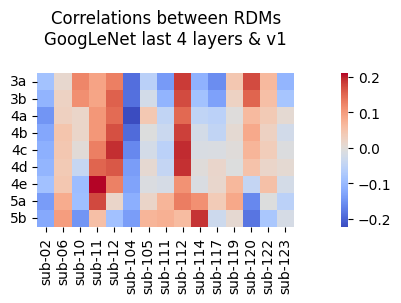

In [ ]:
# @title Correlation between RDMs

roi = roi_list[x]
run = run_list[0]
flatten_neural_RSMs = {}
x += 1

currents = []
for subj in subj_list:
    # if int(subj.replace("sub-", "")) > 100: # slow only
    try:
        rdm = neural_RSMs[roi][run][subj]
        flatten_rdm = rdm[np.tril_indices(rdm.shape[0], -1)]
        flatten_neural_RSMs[subj] = np.arctanh(flatten_rdm) # do Fisher's z-transformation
        currents.append(subj)
    except KeyError:
        pass

flatten_neural_RSMs = pd.DataFrame.from_dict(flatten_neural_RSMs)
n_subj = flatten_neural_RSMs.shape[1]
neural_RSMs_cormat = flatten_neural_RSMs.corr()
neural_RSMs_corflat = np.array(neural_RSMs_cormat)[np.tril_indices(n_subj, -1)]
# sns.boxplot(neural_RSMs_corflat)

flatten_neural_RDMs = np.ones_like(flatten_neural_RSMs) - flatten_neural_RSMs
n_layers = len(layer_names)
cormat = np.corrcoef(flatten_neural_RDMs.T, flatten_RDMs.T)[-n_layers:, :n_subj]

plt.figure(figsize=(12, 2))
ax = sns.heatmap(cormat, cmap="coolwarm", square=True)
ax.set_xticklabels(currents, rotation=90)
ax.set_yticklabels(layer_names, rotation=0)
ax.set_title(f"Correlations between RDMs\nGoogLeNet last 4 layers & {roi}\n", fontsize=12)
plt.show()

In [ ]:
np.mean(cormat, axis=0)

array([-0.08910332,  0.11531098, -0.02832134,  0.07793761,  0.10198004,
        0.07539543,  0.08759152, -0.01359396, -0.05932477,  0.10653215,
        0.10407513, -0.0765273 , -0.02527196,  0.02327487, -0.10451039,
        0.01446328,  0.00494367,  0.12938731, -0.00252419,  0.01454256,
       -0.16883941, -0.02571777, -0.12546214, -0.02182859,  0.13326629,
       -0.06289987,  0.03950898, -0.05694668,  0.27814918,  0.08218375,
        0.08853477,  0.0501819 , -0.07553624, -0.14708759, -0.27213217,
        0.04756094])